1. Eliminate small blobs, does not eliminate blobs with high compactness value
2. Collect typical blob by local blob matching
3. Collect false typical blob by matching blobs with blobs far away in the same section 
    - Set a cut off radius and compare this blob with all the blobs outside this radius on the same section
    - Collect the best matched pair. Or alternatively, randomly sample the outside blob and form a pair
4. Run over the entire brain
    - No need in the first trail,where we just need to get a large enough region. Let's look at the whole image first. 
5. Train the average perceptron with the same features
6. Train the average perceptron with more features


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [2]:
scan_parameters = {}

In [3]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.9
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']
scan_parameters['scan_outside_margin'] = 1000
stack = scan_parameters['stack']

In [4]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [5]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# bbox_7N = bboxs_7N[154]
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [64]:
# Get avaliable sections:
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# load_section_num = 40
# load_start_section = 147 - section_begin
load_start_section = min(sectionList_7N) - 5 - section_begin
load_section_num = max(sectionList_7N) -  min(sectionList_7N) + 10
all_valid_section = fun_get_valid_section_list(stack=stack)
secList = all_valid_section[load_start_section: load_start_section + load_section_num]
scan_parameters['secList'] = secList

In [80]:
secList

[148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316

In [25]:
# # loading data
# image = {}
# for tempSec in secList:
#     try:
#         image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
#     except:
#         sys.stderr.write('Cannot import section %d...\n'%tempSec)
#         continue

In [1]:
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList = scan_parameters['secList'] 
stack = scan_parameters['stack']
# For output
data_typical_blobs = {}
data_matched_paris = {}
data_false_typical_blobs = {}
data_false_matched_pairs = {}
data_blob_prop_dic = {}
data_blob_idx_selection = {}
# section = 154
for section in secList:
    
    typical_blobs = []
    matched_paris = []
    false_typical_blobs = []
    false_matched_paris = []
    cell_centroids = {}
    cell_numbers = {}
    cell_global_coord = {}
    im_blob_prop = {}
    im_label_ori = {}
    im_label = {}
    im_BW = {}
    sec_load_data_list = range(section - scan_range, section + scan_range + 1)
    scan_section = list(sec_load_data_list)
    scan_section.remove(section)
    ### loading data and reconstructed labeled images ###
    tempList = list(sec_load_data_list)
    for tempSec in tempList:
    #         print('process section %d'%tempSec)
        if tempSec in secList:
            cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    #             print('load section %d'%tempSec)
            temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                        oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
#             im_label[tempSec] = temp_im_label
#             im_BW[tempSec] = temp_im_label > 0
            im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
        else:
            sys.stderr.write('Warning: missing section %d'%tempSec)
    #             print(scan_section)
            scan_section.remove(tempSec)
    #             print(scan_section)
    #             print(sec_load_data_list)
            sec_load_data_list.remove(tempSec)
    #             print(sec_load_data_list)

    ### Start getting region properties of each blob    ###
    blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
    data_blob_prop_dic[section] = blob_prop_dic[section] # Save data
    blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
        (blob_prop_dic[tempSec]['compactness']>0,
    #      blob_prop_dic[tempSec]['compactness']<2.5,
         blob_prop_dic[tempSec]['area']<3000,
         blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  

    data_blob_idx_selection[section] = blob_idx_selection[section] # Save data

    n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
    secList_in_BlobPropDic = im_blob_prop.keys()
    if set(scan_section).issubset(set(secList_in_BlobPropDic)):
        pass
    else:
        print('Warrning: Scaned section(s) not included in input im_blob_prop')



    ### Start scanning ###
    for blobID in range(n_blobs[section]):
        if (blobID % 1000 == 0):
            print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))

        temp_curr_blob_props = {}
        for tempProp in prop:
            temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]

        if not blob_idx_selection[section][blobID]:
    #         print('Blob %d eliminated'%blobID)
            continue



        tempB1_idx_loc = temp_curr_blob_props['centroid']
        if o_fix_scan_size:
            temp_next_sec_range, local_cloc = fun_scan_range(
                ,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
        else:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


        for tempSec in scan_section:
    #         print('Blbo %d left. Start scanning'%blobID)
            if tempSec not in secList_in_BlobPropDic:
                continue

            # Find blobs at the nearby location in the scaned section
            tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],temp_next_sec_range,coor_order='cr')
            tempBlobOutside = fun_blobs_out_polygen(blob_prop_dic[tempSec]['centroid'], temp_next_sec_range, coor_order='cr', margin=scan_parameters['scan_outside_margin'])
            tempBlobInsideIndex = np.where(tempBlobInside)[0]
            temp_num_blob = len(tempBlobInsideIndex)
            tempBlobOutsideIndex = np.where(tempBlobOutside)[0]
            temp_num_outblob = len(tempBlobOutsideIndex)

            ### Typical blobs###

            if temp_num_blob:
                temp_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
                temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
                temp_compare_result = temp_weighted_sim > o_simil_threshold
                if any(temp_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    matched_paris.append([section,blobID,
                                          im_blob_prop[section][blobID],
                                          tempSec,
                                          tempBlobInsideIndex[temp_compare_result],
                                          im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],
                                          temp_sim_matrix[temp_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass

            ### False-typical blobs###
            if temp_num_outblob:
                temp_false_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_false_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobOutside],distance_type=temp_prop))
                temp_false_sim_matrix = np.column_stack((temp_false_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_false_sim = np.dot(temp_false_sim_matrix,compare_weight)
                temp_false_compare_result = temp_weighted_false_sim > o_simil_threshold
                if any(temp_false_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    false_typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    false_matched_paris.append([section,blobID,im_blob_prop[section][blobID],
                                                tempSec, 
                                                tempBlobOutsideIndex[temp_false_compare_result], 
                                                im_blob_prop[tempSec][tempBlobOutsideIndex[temp_false_compare_result]],
                                                temp_false_sim_matrix[temp_false_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass
    # fun_save_typical_blobs_info(typical_blobs=typical_blobs, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='typical')
    # fun_save_matched_blobs_info(matched_paris=matched_paris, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='matched')
    # fun_save_typical_blobs_info(typical_blobs=false_typical_blobs, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='false_typical')
    # fun_save_matched_blobs_info(matched_paris=false_matched_paris, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='false_matched')
    data_typical_blobs[section] = typical_blobs
    data_matched_paris[section] = matched_paris
    data_false_typical_blobs[section] = false_typical_blobs
    data_false_matched_pairs[section] = false_matched_paris   

NameError: name 'scan_parameters' is not defined

In [94]:
# This cell deals with an rare case that section 324 is missing and we load data to section 325, so section 326 is also missing. 
data_typical_blobs.pop(325,None)
data_matched_paris.pop(325, None)
data_false_typical_blobs.pop(325, None)
data_false_matched_pairs.pop(325, None)
data_blob_prop_dic.pop(325,None)
secList.remove(325)

# Analyze typical blobs  - Histograms

In [109]:
# Data processing for all the loaded sections
data_typical_blobs_properties = {}
for tempSec in data_typical_blobs.keys():
    data_typical_blobs_properties[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]

data_typical_blobs_properties = fun_regionprops_dic(data_typical_blobs_properties, scan_parameters)
data_typical_blobs_properties_flatten = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten[tempProp] = np.concatenate(tuple([data_typical_blobs_properties[tempSec][tempProp] for tempSec in data_typical_blobs_properties.keys()]))
# dd for delete-duplicated
data_typical_blobs_properties_dd = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties[tempSec]['label'])-1] for tempSec in data_blob_prop_dic.keys()]))
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten = {}
data_selected_blob_props_flatten_dic = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in data_blob_prop_dic.keys()]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten = np.logical_and(data_blob_prop_dic_flatten['area']>200, data_blob_prop_dic_flatten['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic[tempProp] = data_blob_prop_dic_flatten[tempProp][temp_selected_idx_flatten]

In [112]:
# Data processing for all the sections with 7N
data_typical_blobs_properties_7N = {}
for tempSec in sectionList_7N:
    data_typical_blobs_properties_7N[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]
data_typical_blobs_properties_7N = fun_regionprops_dic(data_typical_blobs_properties_7N, scan_parameters)

data_typical_blobs_properties_flatten_7N = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten_7N[tempProp] = np.concatenate(tuple([data_typical_blobs_properties_7N[tempSec][tempProp] for tempSec in data_typical_blobs_properties_7N.keys()]))

# dd for delete-duplicated
data_typical_blobs_properties_dd_7N = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd_7N[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties_7N[tempSec]['label'])-1] for tempSec in data_typical_blobs_properties_7N.keys()]))


In [227]:
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten7N = {}
data_selected_blob_props_flatten_dic7N = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten7N[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in sectionList_7N]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten7N = np.logical_and(data_blob_prop_dic_flatten7N['area']>200, data_blob_prop_dic_flatten7N['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic7N[tempProp] = data_blob_prop_dic_flatten7N[tempProp][temp_selected_idx_flatten7N]

### Typical Ratio

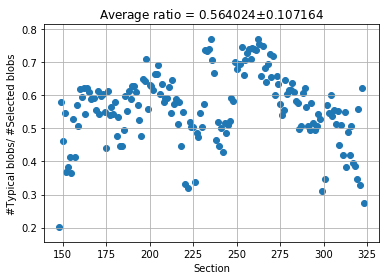

In [159]:
temp_num_typical_blob = [np.count_nonzero(np.unique(data_typical_blobs_properties[tempSec]['label'])) for tempSec in secList]
temp_num_selected_blob = [np.count_nonzero(data_blob_idx_selection[tempSec]) for tempSec in secList]
temp_collect_ratio = np.array(temp_num_typical_blob, dtype=np.float) / np.array(temp_num_selected_blob, dtype=np.float)
plt.scatter(np.array(secList), temp_collect_ratio)
plt.xlabel('Section')
plt.ylabel('#Typical blobs/ #Selected blobs')
plt.grid()
plt.title('Average ratio = %f$\pm$%f'%(np.mean(temp_collect_ratio), np.std(temp_collect_ratio)))

This figure shows the **typical ratio** defined as the ratio between the number of typical blobs found and the number of selected blobs. The ratio is low for the first and the last point (correspond to section 148 and section 323) and that's because they can only find similar blob in one section ( section 147 and section 188 are not included in the loaded data). Given similarity threshold 0.9 and uniform weights on area and eccentricity, about 56% of the selected blobs are found 'typical'. Further work can be figuring out the reason for large section-wise fluctuation.

Assuming that blobs at position $\vec r$ follows a distribution $F(\vec r, \vec{\Phi})$, where $\vec{\Phi}$ is a vector of features that describe the blobs in the space of $V$. $\vec\Phi$ can be (area, eccentricity, orientation, ...) Given a blob at $\vec r$, The blob matching algorithm does the following: 
1. Given a blob at position $\vec r$ from the data, collect blobs inside a ball $B(\vec r, \epsilon)$ whose raidus is $\epsilon$, denoted as set $\{blob_i| \vec r_i \in B(\vec r, \epsilon)\}$. This set can be viewed as a set of samples from distribution $F(\vec r, \vec{\Phi})$
2. Let $\vec\phi$ be a feature vector in the subspace of $V$ and define $d(\vec x,\vec y)$ be a function measures the 'distance' between two vectors $\vec x$ and $\vec y$. The distance between feature vectors measures the similarity between blobs. 
3. Compute the similarity between blob at $\vec r$ and all the blobs in $B(\vec r,\epsilon)$ and get a set of similarities $S(\vec r, \epsilon) = \{d(\vec\phi_i, \vec \phi) | \vec r_i \in B(\vec r, \epsilon) \}$
3. If any of the element of set $S(\vec r, \epsilon)$ is grater than a manually chosen threshold, the blob at $\vec r$ is called 'typical' and stored. 

If the values of the features of the blob at $\vec r$ is rare, it's less likely for it to find similar blobs nearby. Therefore, the 'typical' blobs should form a 'narrower' distribution $f(\vec r, \vec{\Phi})$. 

### Area histograms comparison

Information entropy of Normed_Typical = 2.362551
Information entropy of Normed_Selected = 2.550370


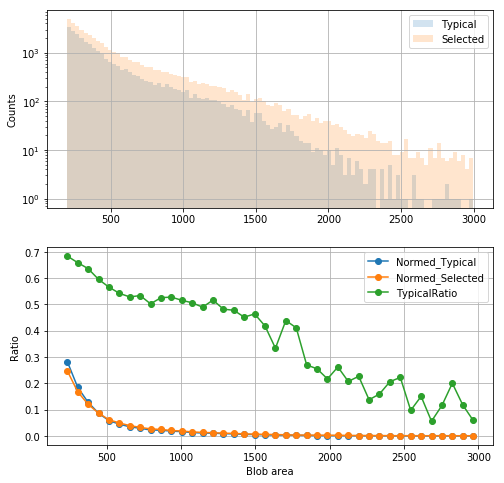

In [244]:
tempProp = 'area'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd[tempProp],bins=100, alpha=0.2, label='Typical');
plt.hist(data_selected_blob_props_flatten_dic[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper right')
plt.yscale('log')
plt.grid()
plt.ylabel('Counts')
plt.subplot(2,1,2)
temp_num_bin = 40
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=(200,3000))
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=(200,3000))
tempLabel1 = 'Normed_Typical'
tempLabel2 = 'Normed_Selected'
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(np.sum(temp1[0]) + 0.00000001), label=tempLabel1, linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.00000001)/(np.sum(temp2[0]) + 0.00000001), label=tempLabel2,linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(temp2[0] + 0.00000001), label='TypicalRatio',linestyle='-', marker='o')
plt.legend(loc='upper right')

plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

Information entropy of Normed_Typical7N = 2.624963
Information entropy of Normed_Selected = 2.759452


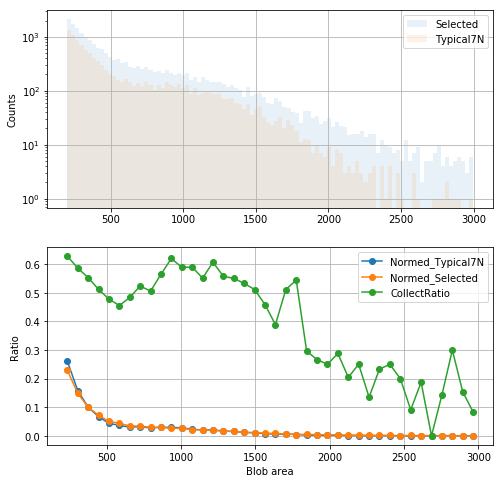

In [245]:
tempProp = 'area'
temp_num_bin = 40
temp1 = np.histogram(data_typical_blobs_properties_dd_7N[tempProp], bins=temp_num_bin,range=(200,3000))
temp2 = np.histogram(data_selected_blob_props_flatten_dic7N[tempProp], bins=temp_num_bin,range=(200,3000))
tempLabel1 = 'Normed_Typical7N'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))


plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_selected_blob_props_flatten_dic7N[tempProp],bins=100, alpha=0.1, label='Selected');
plt.hist(data_typical_blobs_properties_dd_7N[tempProp],bins=100, alpha=0.1, label='Typical7N');
# plt.hist(data_typical_blobs_properties_dd[tempProp],bins=100, alpha=0.1, label='Typical');
plt.legend(loc='upper right')
plt.yscale('log')
plt.grid()
plt.ylabel('Counts')
plt.subplot(2,1,2)

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(np.sum(temp1[0]) + 0.000000000001), label='Normed_Typical7N', linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.00000001)/(np.sum(temp2[0]) + 0.000000000001), label='Normed_Selected',linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='upper right')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()



Ratio of binned compactness counts between typical blobs and selected blobs
1. It seems that blobs of different compactness are eliminated unbiasely in the matching process. For compactness in (1,3), the ratio seems flat. Any way to quantify the unbiased elimination? 

2. Need to plot the standard deviation:
    - bin ratio according to compactness
    - compute the standard deviation for each bin 
    - plot scatter point with error bar
    - alternative: box plot: plt.boxplot([data_typical_blobs_properties_dd['area'], ])


### Eccentricity 

Information entropy of Normed_Typical = 3.124441
Information entropy of Normed_Selected = 3.401011


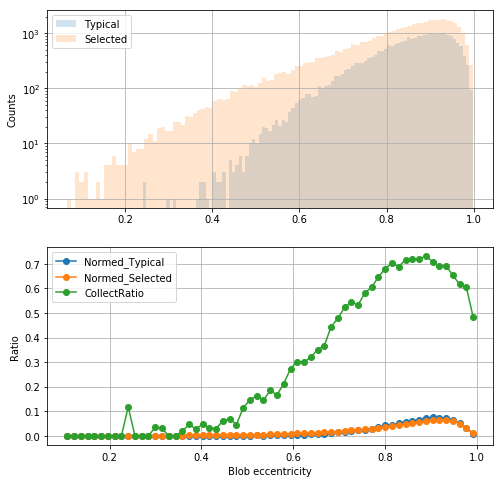

In [237]:
tempProp = 'eccentricity'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd[tempProp],bins=100, alpha=0.2, label='Typical');
plt.hist(data_selected_blob_props_flatten_dic[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper left')
plt.grid()
plt.ylabel('Counts')
plt.yscale('log')
plt.subplot(2,1,2)
temp_num_bin = 61
temp_range = (0.1,1)
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(np.sum(temp1[0]) + 0.000000000001), label='Normed_Typical', linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.00000001)/(np.sum(temp2[0]) + 0.000000000001), label='Normed_Selected',linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='upper left')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

Information entropy of Normed_Typical7N = 3.110869
Information entropy of Normed_Selected = 3.392850


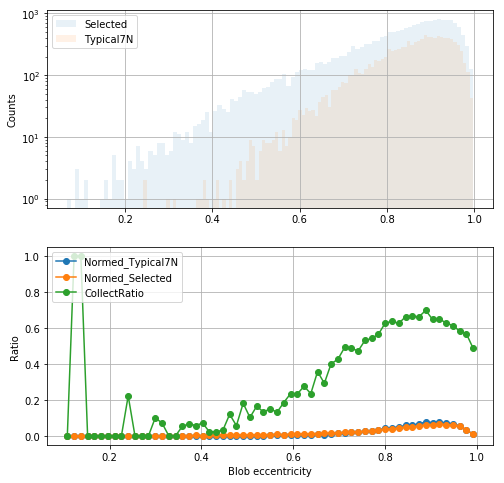

In [250]:
tempProp = 'eccentricity'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_selected_blob_props_flatten_dic7N[tempProp],bins=100, alpha=0.1, label='Selected');
plt.hist(data_typical_blobs_properties_dd_7N[tempProp],bins=100, alpha=0.1, label='Typical7N');
plt.legend(loc='upper left')
plt.grid()
plt.ylabel('Counts')
plt.yscale('log')
plt.subplot(2,1,2)
temp_num_bin = 61
temp_range = (0.1,1)
temp1 = np.histogram(data_typical_blobs_properties_dd_7N[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic7N[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical7N'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(np.sum(temp1[0]) + 0.000000000001), label='Normed_Typical7N', linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.000000000001)/(np.sum(temp2[0]) + 0.000000000001), label='Normed_Selected',linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='upper left')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

### Compactness

Information entropy of Normed_Typical = 2.210811
Information entropy of Normed_Selected = 2.314610


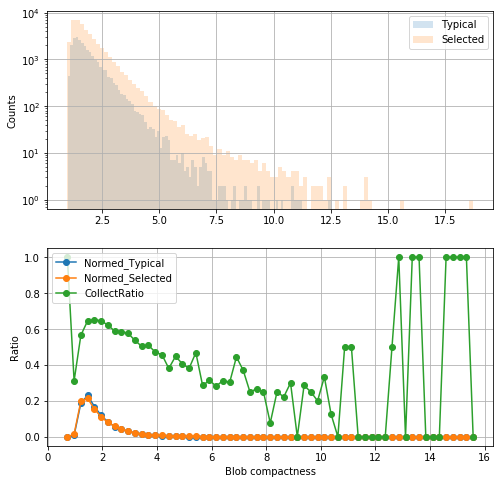

In [239]:
tempProp = 'compactness'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd[tempProp],bins=100, alpha=0.2, label='Typical');
plt.hist(data_selected_blob_props_flatten_dic[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper right')
plt.grid()
plt.ylabel('Counts')
plt.yscale('log')
plt.subplot(2,1,2)
temp_num_bin = 61
temp_range = (0.6,15.7)

temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(np.sum(temp1[0]) + 0.000000000001), label='Normed_Typical', linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.000000000001)/(np.sum(temp2[0]) + 0.000000000001), label='Normed_Selected',linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='upper left')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

Information entropy of Normed_Typical7N = 2.236440
Information entropy of Normed_Selected = 2.324312


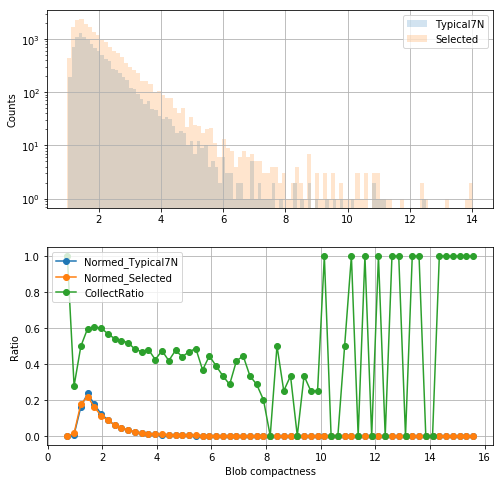

In [240]:
tempProp = 'compactness'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd_7N[tempProp],bins=100, alpha=0.2, label='Typical7N');
plt.hist(data_selected_blob_props_flatten_dic7N[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper right')
plt.grid()
plt.ylabel('Counts')
plt.yscale('log')
plt.subplot(2,1,2)
temp_num_bin = 61
temp_range = (0.6,15.7)

temp1 = np.histogram(data_typical_blobs_properties_dd_7N[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic7N[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical7N'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(np.sum(temp1[0]) + 0.000000000001), label=tempLabel1, linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.000000000001)/(np.sum(temp2[0]) + 0.000000000001), label=tempLabel2,linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='upper left')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

### Orientation

Information entropy of Normed_Typical = 3.609342
Information entropy of Normed_Selected = 3.629600


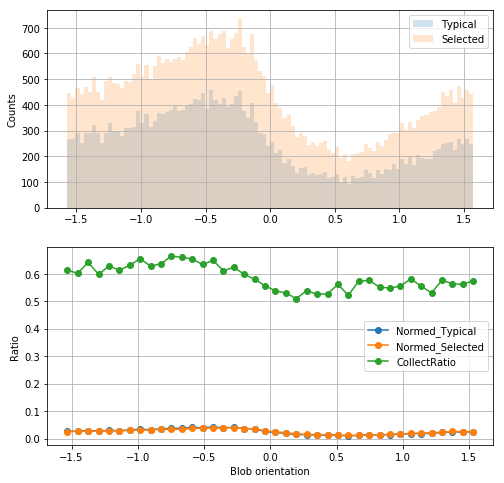

In [241]:
tempProp = 'orientation'
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd[tempProp],bins=100, alpha=0.2, label='Typical');
plt.hist(data_selected_blob_props_flatten_dic[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper right')
plt.grid()
plt.ylabel('Counts')
plt.subplot(2,1,2)
PI = 3.1415926
temp_num_bin = 40
temp_range = (-PI/2 ,PI/2)
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(np.sum(temp1[0]) + 0.000000000001), label='Normed_Typical', linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.000000000001)/(np.sum(temp2[0]) + 0.000000000001), label='Normed_Selected',linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='right')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

Information entropy of Normed_Typical7N = 3.594153
Information entropy of Normed_Selected = 3.613314


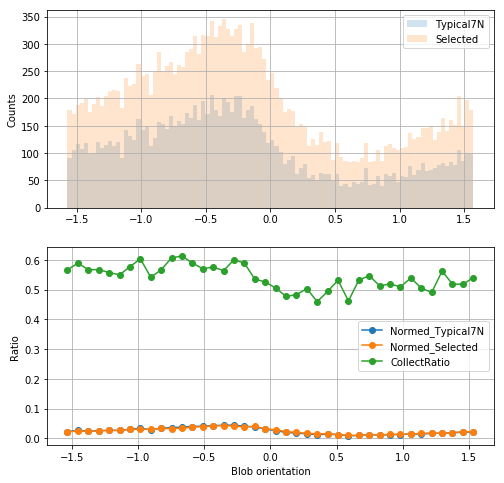

In [242]:
tempProp = 'orientation'
PI = 3.1415926
temp_num_bin = 40
temp_range = (-PI/2 ,PI/2)
temp1 = np.histogram(data_typical_blobs_properties_dd_7N[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic7N[tempProp], bins=temp_num_bin,range=temp_range)
tempLabel1 = 'Normed_Typical7N'
tempLabel2 = 'Normed_Selected'
temp1_norm = temp1[0].astype(np.float)/np.sum(temp1[0]) + 10**(-16)
temp2_norm = temp2[0].astype(np.float)/np.sum(temp2[0]) + 10**(-16)
print('Information entropy of %s = %f'%(tempLabel1, np.dot(temp1_norm, -np.log(temp1_norm))))
print('Information entropy of %s = %f'%(tempLabel2, np.dot(temp2_norm, -np.log(temp2_norm))))

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.hist(data_typical_blobs_properties_dd_7N[tempProp],bins=100, alpha=0.2, label='Typical7N');
plt.hist(data_selected_blob_props_flatten_dic7N[tempProp],bins=100, alpha=0.2, label='Selected');
plt.legend(loc='upper right')
plt.grid()
plt.ylabel('Counts')
plt.subplot(2,1,2)


plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(np.sum(temp1[0]) + 0.000000000001), label=tempLabel1, linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp2[0]+0.000000000001)/(np.sum(temp2[0]) + 0.000000000001), label=tempLabel2,linestyle='-', marker='o')
plt.plot(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.000000000001), label='CollectRatio',linestyle='-', marker='o')
plt.legend(loc='right')
plt.xlabel('Blob ' + tempProp )
plt.ylabel('Ratio')
plt.grid()

# Analyze mis-matched blobs